# Creating Graph Database of Lawmakers, Committees, and Bills

__A project by Joy Payton and Sonya Hong__

The project assignment:

* Identify and load a network dataset that has some categorical information available for each node.
* For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
* Compare your centrality measures across your categorical groups.


In this project, Joy and Sonya:
* Work with [ProPublica's Congress API](https://projects.propublica.org/api-docs/congress-api/)
* Create nodes for Senators
* Create edges for "co-sponsorship" -- senators who sponsor bills with each other 
* Create edges for "committee member with" -- senators who are on a committee with each other

The goal:
* Explore centrality measures
* Demonstrate any differences in centrality measures across categorical groups

## Import Needed Packages

In [95]:
import requests
import json
import networkx as net
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Create Function to Run API

In [2]:
def propublica(url):
    r = requests.get(url, headers={'X-API-Key': '### REDACTED ###'})  
    data = json.loads(r.text)
    return (data)

## Get List of Senators via API

In [96]:
senators = propublica("https://api.propublica.org/congress/v1/115/senate/members.json")['results'][0]['members']
df_senators = pd.DataFrame(senators)
df_senators.head()

,api_uri,contact_form,crp_id,cspan_id,date_of_birth,dw_nominate,facebook_account,fax,first_name,google_entity_id,...,state,state_rank,title,total_present,total_votes,twitter_account,url,votes_with_party_pct,votesmart_id,youtube_account
0,https://api.propublica.org/congress/v1/members...,http://www.alexander.senate.gov/public/index.c...,N00009888,5,1940-07-03,0.323,senatorlamaralexander,202-228-3398,Lamar,/m/01rbs3,...,TN,senior,"Senator, 2nd Class",0,208,SenAlexander,https://www.alexander.senate.gov/public/,98.51,15691,lamaralexander
1,https://api.propublica.org/congress/v1/members...,https://www.blunt.senate.gov/public/index.cfm/...,N00005195,45465,1950-01-10,0.431,SenatorBlunt,202-224-8149,Roy,/m/034fn4,...,MO,junior,"Senator, 3rd Class",0,208,RoyBlunt,https://www.blunt.senate.gov/public/,99.03,418,SenatorBlunt
2,https://api.propublica.org/congress/v1/members...,http://www.brown.senate.gov/contact/,N00003535,5051,1952-11-09,-0.440,None,202-228-6321,Sherrod,/m/034s80,...,OH,senior,"Senator, 1st Class",1,208,SenSherrodBrown,https://www.brown.senate.gov/,94.71,27018,SherrodBrownOhio
3,https://api.propublica.org/congress/v1/members...,https://www.burr.senate.gov/contact/email,N00002221,31054,1955-11-30,0.454,SenatorRichardBurr,202-228-2981,Richard,/m/03g_s9,...,NC,senior,"Senator, 3rd Class",0,208,SenatorBurr,https://www.burr.senate.gov/,99.49,21787,SenatorRichardBurr
4,https://api.propublica.org/congress/v1/members...,https://www.baldwin.senate.gov/feedback,N00004367,57884,1962-02-11,-0.546,TammyBaldwin,202-225-6942,Tammy,/m/024v02,...,WI,junior,"Senator, 1st Class",1,208,SenatorBaldwin,https://www.baldwin.senate.gov/,95.19,3470,witammybaldwin


### Show the Column Names

This way we can select promising categorical variables we want to keep.

In [97]:
df_senators.columns

Index([u'api_uri', u'contact_form', u'crp_id', u'cspan_id', u'date_of_birth',
       u'dw_nominate', u'facebook_account', u'fax', u'first_name',
       u'google_entity_id', u'govtrack_id', u'icpsr_id', u'id', u'ideal_point',
       u'in_office', u'last_name', u'leadership_role', u'lis_id',
       u'middle_name', u'missed_votes', u'missed_votes_pct', u'next_election',
       u'ocd_id', u'office', u'party', u'phone', u'rss_url', u'senate_class',
       u'seniority', u'short_title', u'state', u'state_rank', u'title',
       u'total_present', u'total_votes', u'twitter_account', u'url',
       u'votes_with_party_pct', u'votesmart_id', u'youtube_account'],
      dtype='object')

### Simplify the Senators for Graphing

Let's get rid of superfluous information and stick with just the basics.  State Rank and Party make for good categorical variables, and we'll want name and ID to be able to identify our nodes.

In [98]:
simplifiedSenators = [dict.fromkeys(["id", "first_name", "middle_name", "last_name", "party", "seniority", "state_rank"])]

for senator in senators:
    simplifiedSenator = {key: senator[key] for key in senator if key in \
                      ['id','first_name','middle_name','last_name','party','seniority','state_rank']}
    simplifiedSenators.append(simplifiedSenator)

Let's take a look at the simplified senators:

In [99]:
pd.DataFrame(simplifiedSenators).head()

,first_name,id,last_name,middle_name,party,seniority,state_rank
0,None,None,None,None,None,None,None
1,Lamar,A000360,Alexander,None,R,15,senior
2,Roy,B000575,Blunt,None,R,7,junior
3,Sherrod,B000944,Brown,None,D,11,senior
4,Richard,B001135,Burr,M.,R,13,senior


That "None" row is going to cause a problem!  I'll remove it.

In [100]:
simplifiedSenators.pop(0)
pd.DataFrame(simplifiedSenators).head()

,first_name,id,last_name,middle_name,party,seniority,state_rank
0,Lamar,A000360,Alexander,None,R,15,senior
1,Roy,B000575,Blunt,None,R,7,junior
2,Sherrod,B000944,Brown,None,D,11,senior
3,Richard,B001135,Burr,M.,R,13,senior
4,Tammy,B001230,Baldwin,None,D,5,junior


### Start a Graph With Senators as nodes

In [101]:
g = net.Graph()
for senator in simplifiedSenators:
    if (senator['id'] != None):
        g.add_node(senator['id'], attr_dict=senator)

## Get Committee Memberships

Committee membership will give us some edges to work with!

### Get Committees

In [102]:
committees = propublica("https://api.propublica.org/congress/v1/115/senate/committees.json")['results'][0]['committees']
df_committees = pd.DataFrame(committees)
df_committees.head()

,api_uri,chair,chair_id,chair_party,chair_state,chair_uri,chamber,id,name,ranking_member_id,subcommittees,url
0,https://api.propublica.org/congress/v1/115/sen...,Pat Roberts,R000307,R,KS,https://api.propublica.org/congress/v1/members...,Senate,SSAF,"Committee on Agriculture, Nutrition, and Forestry",S000770,[{u'api_uri': u'https://api.propublica.org/con...,https://www.agriculture.senate.gov/
1,https://api.propublica.org/congress/v1/115/sen...,Thad Cochran,C000567,R,MS,https://api.propublica.org/congress/v1/members...,Senate,SSAP,Committee on Appropriations,M000702,[{u'api_uri': u'https://api.propublica.org/con...,https://www.appropriations.senate.gov/
2,https://api.propublica.org/congress/v1/115/sen...,John McCain,M000303,R,AZ,https://api.propublica.org/congress/v1/members...,Senate,SSAS,Committee on Armed Services,R000122,[{u'api_uri': u'https://api.propublica.org/con...,https://www.armed-services.senate.gov/
3,https://api.propublica.org/congress/v1/115/sen...,Michael D. Crapo,C000880,R,ID,https://api.propublica.org/congress/v1/members...,Senate,SSBK,"Committee on Banking, Housing, and Urban Affairs",B000944,[{u'api_uri': u'https://api.propublica.org/con...,https://www.banking.senate.gov/public/
4,https://api.propublica.org/congress/v1/115/sen...,John Thune,T000250,R,SD,https://api.propublica.org/congress/v1/members...,Senate,SSCM,"Committee on Commerce, Science, and Transporta...",N000032,[{u'api_uri': u'https://api.propublica.org/con...,https://www.commerce.senate.gov/public/


### Get Senators in Each Committee and Connect Them

In [103]:
for committee in df_committees['id']:
    members = propublica("https://api.propublica.org/congress/v1/115/senate/committees/" + committee + ".json")\
        ['results'][0]['current_members']
    print "Getting members for the " + committee + " committee."
    df_members = pd.DataFrame(members)
    
    # We want to connect all the members of the committee.
    
    for i in range(0,len(df_members['id'])): # for each member of the committee
        for j in range (i+1,len(df_members['id'])): # take each subsequent member (later down the series)
            g.add_edge(df_members['id'][i],df_members['id'][j]) # and create an edge

Getting members for the SSAF committee.
Getting members for the SSAP committee.
Getting members for the SSAS committee.
Getting members for the SSBK committee.
Getting members for the SSCM committee.
Getting members for the SSEG committee.
Getting members for the SSEV committee.
Getting members for the SSFI committee.
Getting members for the SSFR committee.
Getting members for the SSHR committee.
Getting members for the SSGA committee.
Getting members for the SLIA committee.
Getting members for the SSRA committee.
Getting members for the SSSB committee.
Getting members for the SSBU committee.
Getting members for the SSJU committee.
Getting members for the SSVA committee.
Getting members for the SLET committee.
Getting members for the SLIN committee.
Getting members for the SPAG committee.


## Get Bills

Senate bills each have sponsors, and sometimes co-sponsors. 

### Get Recent Active Bills

The API will only send 20 at a go, so we have to paginate!

In [104]:
url = "https://api.propublica.org/congress/v1/115/senate/bills/active.json?offset="
offset = 0
apiResults = propublica(url + str(offset))
activeBills = apiResults['results'][0]['bills']
while True:
    offset = offset + 20
    apiResults = propublica(url + str(offset))
    moreBills = apiResults['results'][0]['bills']
    if len(moreBills) == 0:
        break
    activeBills += moreBills
    time.sleep(.25)  # Be friendly and don't overwhelm the server with a bunch of fast queries

How many bills do we have?

In [105]:
len(activeBills)

375

In [106]:
df_activeBills = pd.DataFrame(activeBills)
df_activeBills.head()

,active,bill_id,bill_slug,bill_type,bill_uri,committee_codes,committees,congressdotgov_url,cosponsors,enacted,...,sponsor_name,sponsor_party,sponsor_state,sponsor_title,sponsor_uri,subcommittee_codes,summary,summary_short,title,vetoed
0,True,s1866-115,s1866,s,https://api.propublica.org/congress/v1/115/bil...,[],,https://www.congress.gov/bill/115th-congress/s...,0,2017-09-28,...,Lamar Alexander,R,TN,Sen.,https://api.propublica.org/congress/v1/members...,[],,,"Hurricanes Harvey, Irma, and Maria Education R...",None
1,True,s810-115,s810,s,https://api.propublica.org/congress/v1/115/bil...,"[HSPW, SSEV]",House Transportation and Infrastructure Committee,https://www.congress.gov/bill/115th-congress/s...,1,2017-09-27,...,Roy Blunt,R,MO,Sen.,https://api.propublica.org/congress/v1/members...,"[HSPW07, HSPW12]",This bill authorizes the construction and oper...,This bill authorizes the construction and oper...,A bill to facilitate construction of a bridge ...,None
2,True,sres269-115,sres269,sres,https://api.propublica.org/congress/v1/115/bil...,[],,https://www.congress.gov/bill/115th-congress/s...,7,None,...,Robert Menendez,D,NJ,Sen.,https://api.propublica.org/congress/v1/members...,[],,,"A resolution designating September 2017 as ""Na...",None
3,True,s1519-115,s1519,s,https://api.propublica.org/congress/v1/115/bil...,[SSAS],Senate Armed Services Committee,https://www.congress.gov/bill/115th-congress/s...,0,None,...,John McCain,R,AZ,Sen.,https://api.propublica.org/congress/v1/members...,[],National Defense Authorization Act for Fiscal ...,National Defense Authorization Act for Fiscal ...,National Defense Authorization Act for Fiscal ...,None
4,True,s1057-115,s1057,s,https://api.propublica.org/congress/v1/115/bil...,[SSCM],"Senate Commerce, Science, and Transportation C...",https://www.congress.gov/bill/115th-congress/s...,7,None,...,Bill Nelson,D,FL,Sen.,https://api.propublica.org/congress/v1/members...,[],,,Harmful Algal Bloom and Hypoxia Research and C...,None


### Get Sponsor and Cosponsors of Every Bill

First, find the bills that had some cosponsors but that weren't runaway, whole-party or whole-senate cosponsorships.  We're looking for the sweet spot between, say, 1 and 20 co-sponsors, where the group of sponsors is small enough that working together on the bill would be an actual social connection, not just a rubber-stamp.

In [107]:
cosponsoredBills = df_activeBills[(df_activeBills['cosponsors'] > 0) & (df_activeBills['cosponsors'] <= 20)]
cosponsoredBills = cosponsoredBills[['bill_slug','sponsor_id', 'cosponsors']]
cosponsoredBills

,bill_slug,sponsor_id,cosponsors
1,s810,B000575,1
2,sres269,M000639,7
4,s1057,N000032,7
5,s1028,C001035,14
7,s504,H001042,3
8,s327,H001041,2
9,sres114,Y000064,7
10,s607,U000039,2
11,s1141,S001181,4
12,s842,B001288,7


Then, lookup the info on each cosponsored bill, collect all the sponsors of that bill (principle and cosponsor), and link them with edges.

In [108]:
for index, row in cosponsoredBills.iterrows():
    sponsorList = [row['sponsor_id']]  # Start the list with the principle sponsor
    # Get the cosponsorship info on this bill
    cosponsorInfo = pd.DataFrame(propublica("https://api.propublica.org/congress/v1/115/bills/" + \
                                            row['bill_slug'] + "/cosponsors.json")\
                                            ['results'][0]['cosponsors'])
    # Add the co-sponsors to the list of sponsors
    sponsorList = sponsorList + cosponsorInfo['cosponsor_id'].tolist()
    
    print "The sponsors for " + row['bill_slug'] + " are " + str(sponsorList)
    # Then, for each member of the list, create the links, similar to how we did with committees.
    for i in range(0,len(sponsorList)): # for each sponsor
        for j in range (i+1,len(sponsorList)): # take each subsequent sponsor (later down the list)
            g.add_edge(sponsorList[i],sponsorList[j]) # and create an edge

The sponsors for s810 are [u'B000575', u'M001170']
The sponsors for sres269 are [u'M000639', u'C000880', u'M000133', u'F000062', u'C000141', u'B001288', u'B000575', u'C001088']
The sponsors for s1057 are [u'N000032', u'P000449', u'P000595', u'S001198', u'B001230', u'B000944', u'M001153', u'S000148']
The sponsors for s1028 are [u'C001035', u'B001230', u'M001153', u'B001267', u'S000770', u'C001088', u'D000607', u'F000457', u'W000817', u'K000367', u'N000032', u'M001176', u'T000464', u'C001047', u'S001181']
The sponsors for s504 are [u'H001042', u'D000618', u'K000367', u'G000562']
The sponsors for s327 are [u'H001041', u'P000595', u'P000612']
The sponsors for sres114 are [u'Y000064', u'C000141', u'G000562', u'C001088', u'R000595', u'B001236', u'B001288', u'M001176']
The sponsors for s607 are [u'U000039', u'T000464', u'C000127']
The sponsors for s1141 are [u'S001181', u'C001047', u'R000595', u'C001088', u'C000141']
The sponsors for s842 are [u'B001288', u'J000293', u'B001230', u'E000295', u

## Check out the Graph

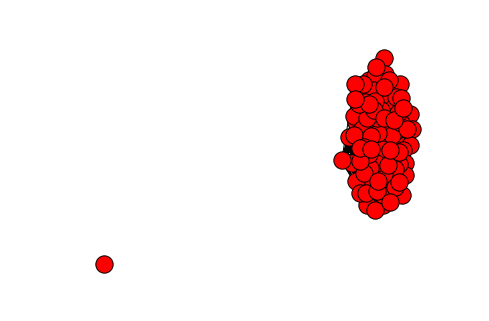

In [109]:
net.draw(g)

Who's our lonely isolate?

In [110]:
net.isolates(g)

[u'S001141']

In [111]:
net.get_node_attributes(g,'last_name').get('S001141')

u'Sessions'

It's unsurprising that Sessions is our isolate, as he left the Senate to become the Attorney General, and therefore does not continue in any committees or sponsor any bills, but is still listed as a Senator during this senate session.

### Get some metrics

We'll start with degree, and turn the data into a Pandas data frame so we can easily combine it with categorical data in order to measure centrality by category!

In [112]:
degree = pd.DataFrame(net.degree(g).items())
degree.columns = [
  'senator',
  'degree'
]
degree

,senator,degree
0,L000174,82
1,B001288,83
2,W000779,86
3,S001184,87
4,M001176,86
5,T000476,90
6,M001170,82
7,S001181,94
8,C000567,68
9,V000128,91


What's the size of the graph?

In [113]:
g.size()

4168

How many nodes are there?

In [114]:
net.number_of_nodes(g)

101

And how many edges (co-committee memberships?)

In [115]:
g.number_of_edges()

4168

What about degree centrality?

In [116]:
dg = net.degree_centrality(g)

In [117]:
dg_sorted = sorted(dg.iteritems(),key=lambda(k,v):(-v,k))

degreeCentrality = pd.DataFrame(dg_sorted)
degreeCentrality.columns = [
  'senator',
  'degree_centrality'
]
degreeCentrality

,senator,degree_centrality
0,F000062,0.95
1,K000383,0.94
2,R000595,0.94
3,S001181,0.94
4,T000464,0.94
5,B000944,0.93
6,C001056,0.93
7,C001088,0.93
8,B001277,0.92
9,F000463,0.92


What about eigenvector centrality?

In [118]:
eg = net.eigenvector_centrality(g)
eg_sorted = sorted(eg.iteritems(),key=lambda(k,v):(-v,k))


eigenvectorCentrality = pd.DataFrame(eg_sorted)
eigenvectorCentrality.columns = [
  'senator',
  'eigenvector_centrality'
]
eigenvectorCentrality

,senator,eigenvector_centrality
0,F000062,0.112645
1,S001181,0.112091
2,R000595,0.111901
3,T000464,0.111756
4,K000383,0.111365
5,C001088,0.110904
6,B000944,0.110833
7,C001056,0.110487
8,B001277,0.109906
9,P000595,0.109730


### Combine Data

We have several data frames we want to combine!

In [119]:
all_data = degree.merge(degreeCentrality).merge(eigenvectorCentrality)\
                 .merge(pd.DataFrame(simplifiedSenators), left_on='senator', right_on = 'id')
all_data

,senator,degree,degree_centrality,eigenvector_centrality,first_name,id,last_name,middle_name,party,seniority,state_rank
0,L000174,82,0.82,0.098233,Patrick,L000174,Leahy,J.,D,43,senior
1,B001288,83,0.83,0.099615,Cory,B001288,Booker,None,D,5,junior
2,W000779,86,0.86,0.102414,Ron,W000779,Wyden,None,D,22,senior
3,S001184,87,0.87,0.103956,Tim,S001184,Scott,None,R,5,junior
4,M001176,86,0.86,0.103022,Jeff,M001176,Merkley,None,D,9,junior
5,T000476,90,0.90,0.107306,Thom,T000476,Tillis,None,R,3,junior
6,M001170,82,0.82,0.097832,Claire,M001170,McCaskill,None,D,11,senior
7,S001181,94,0.94,0.112091,Jeanne,S001181,Shaheen,None,D,9,senior
8,C000567,68,0.68,0.082510,Thad,C000567,Cochran,None,R,39,senior
9,V000128,91,0.91,0.108619,Chris,V000128,Van Hollen,None,D,1,junior


## Analyze by Categorical Variables

In [120]:
all_data['party'].unique()

array([u'D', u'R', u'I'], dtype=object)

In [121]:
republican = all_data['party'] == 'R'
democrat = all_data['party'] == 'D'
independent = all_data['party'] == 'I'
senior = all_data['state_rank'] == "senior"
junior = all_data['state_rank'] == "junior"

In [122]:
print "Degree Centrality R: " + str(all_data[republican]['degree_centrality'].mean())
print "Degree Centrality D: " + str(all_data[democrat]['degree_centrality'].mean())
print "Degree Centrality I: " + str(all_data[independent]['degree_centrality'].mean())

Degree Centrality R: 0.797358490566
Degree Centrality D: 0.85347826087
Degree Centrality I: 0.92


In [123]:
print "Degree Centrality Senior: " + str(all_data[senior]['degree_centrality'].mean())
print "Degree Centrality Junior: " + str(all_data[junior]['degree_centrality'].mean())

Degree Centrality Senior: 0.8414
Degree Centrality Junior: 0.8258


In [124]:
print "Eigenvector Centrality R: " + str(all_data[republican]['eigenvector_centrality'].mean())
print "Eigenvector Centrality D: " + str(all_data[democrat]['eigenvector_centrality'].mean())
print "Eigenvector Centrality I: " + str(all_data[independent]['eigenvector_centrality'].mean())

Eigenvector Centrality R: 0.0952114829113
Eigenvector Centrality D: 0.101978005801
Eigenvector Centrality I: 0.109193627962


In [125]:
print "Eigenvector Centrality Senior: " + str(all_data[senior]['eigenvector_centrality'].mean())
print "Eigenvector Centrality Junior: " + str(all_data[junior]['eigenvector_centrality'].mean())

Eigenvector Centrality Senior: 0.100493829964
Eigenvector Centrality Junior: 0.0986178523766


## Conclusions

It seems (leaving aside the infrequent Independent) that Democrats have higher centrality metrics than Republicans (but not by too much).  It would be interesting to see if being the minority party requires more social networking to get things accomplished and therefore promotes greater higher centrality measures.

We also see that and senior-ranking senators have greater centrality than junior senators (which makes sense).

Future steps might include weighting edges differentially.  Maybe co-sponsoring a bill is more socially intimate than simply sharing a committee, or being one of three co-sponsors reflects a stronger social bond than being one of ten sponsors of a bill.